In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
!pip install segmentation-models-pytorch

In [ ]:
import cv2
import glob
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import shutil
import random
import time
from pathlib import Path

import albumentations as A

import segmentation_models_pytorch as smp

import torchvision.transforms.functional as TF
import torch.nn.functional as F

sns.set_style("dark")

DATA_ROOT = "/content/drive/MyDrive/Project_Tasks/Crop_boundary_delineation/agri_survey/"
MODEL_DIR = DATA_ROOT + "saved_outputs/"
IMGS_DIR = DATA_ROOT + "images/"
MASKS_DIR = DATA_ROOT + "annotations/project_labels/"

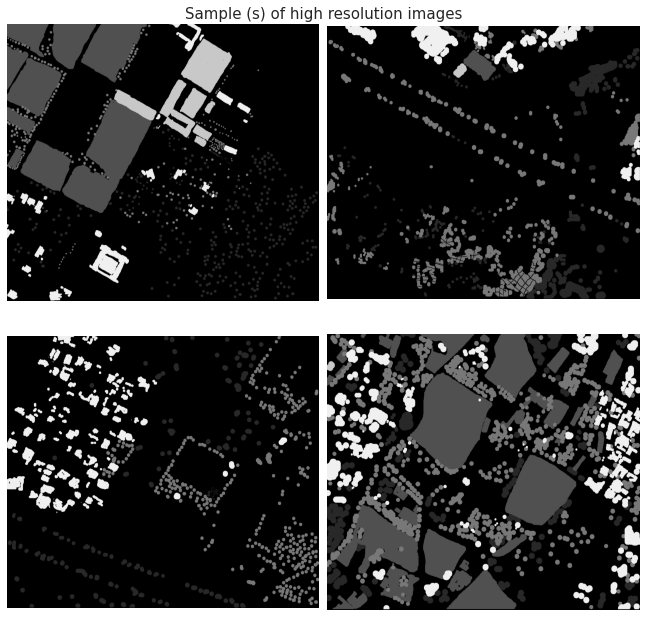

In [ ]:
############ Visualising original Masks
images_list = sorted(list(glob.glob(os.path.join(MASKS_DIR, "*.png"))))
samples = [0,1,2,3]
fig, ax = plt.subplots(figsize = (9,9), nrows = 2, ncols =2)
for i, sample in enumerate(samples):
    r,c = divmod(i,2)
    ax[r,c].imshow(cv2.imread(images_list[sample])*40)
    ax[r,c].axis("off")
plt.suptitle("Sample (s) of high annotated masks", fontsize = 15)
plt.tight_layout(pad=0.8)
#plt.savefig("Samples.png")
plt.show()

In [ ]:
#~~~~~~~~~ splitting the orignal images and masks into sub-images ~~~~~~~~~~~~~~
##Need not to run unless we don't have split images
SPLIT_OUTPUT_DIR = "/content/drive/MyDrive/Project_Tasks/Crop_boundary_delineation/agri_survey/split/"
if not os.path.exists(SPLIT_OUTPUT_DIR):
    os.mkdir(SPLIT_OUTPUT_DIR)
SPLIT_IMAGE_DIR = "/content/drive/MyDrive/Project_Tasks/Crop_boundary_delineation/agri_survey/split/images_2/"
if not os.path.exists(SPLIT_IMAGE_DIR):
    os.mkdir(SPLIT_IMAGE_DIR)
SPLIT_MASK_DIR = "/content/drive/MyDrive/Project_Tasks/Crop_boundary_delineation/agri_survey/split/masks_2/"
if not os.path.exists(SPLIT_MASK_DIR):
    os.mkdir(SPLIT_MASK_DIR)

IMG_PATHS = glob.glob(os.path.join(IMGS_DIR, "*.png"))
MASK_PATHS = glob.glob(os.path.join(MASKS_DIR, "*.png"))

IMAGE_SIZE = 512
model_name = 'Vanilla_Unet'
dataset_name = 'Agri_survey_'
def split_images(TARGET_SIZE = IMAGE_SIZE):
    """
    A function to split the aerial images into squared images of
    size equal to TARGET_SIZE. Stores the new images into
    a directory named output, located in working directory.
    """
    tic = time.time()
    print(f"Splitting the images...\n")
    img_paths = sorted(glob.glob(os.path.join(IMGS_DIR, "*.png")))
    mask_paths = sorted(glob.glob(os.path.join(MASKS_DIR, "*.png")))
    
    for i, (img_path, mask_path) in sorted(enumerate(zip(img_paths, mask_paths))):
        img_filename = os.path.splitext(os.path.basename(img_path))[0]
        mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

        k = 0
        for y in range(0, img.shape[0], TARGET_SIZE):
            for x in range(0, img.shape[1], TARGET_SIZE):
                img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
                mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

                if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                    out_img_path = os.path.join(SPLIT_IMAGE_DIR, "{}_{}.jpg".format(img_filename, k))
                    cv2.imwrite(out_img_path, img_tile)

                    out_mask_path = os.path.join(SPLIT_MASK_DIR, "{}_{}.png".format(mask_filename, k))
                    cv2.imwrite(out_mask_path, mask_tile)
                    k += 1

        print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))
    mins,sec = divmod(time.time()-tic,60)
    print(f"Execution completed in {mins} minutes and {sec:.2f} seconds.")


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~ Segmentation Dataset class~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

class SegmentationDataset(Dataset):
    """
    The main class that handles the dataset. Reads the images from
    SPLIT_IMAGE_DIR & SPLIT_MASK_DIR, handles the data augmentation transformations and converts
    the numpy images to tensors.
    """
    def __init__(self, mode = "train", ratio = None, transforms = None, seed = 28):
        self.mode = mode
        self.transforms = transforms
        self.output_img_dir = DATA_ROOT + 'split/images_2/'
        self.output_mask_dir = DATA_ROOT + 'split/masks_2/'
        self.data_root = DATA_ROOT 
        
        if mode in ["train", "test", "val"]:
            with open(os.path.join(self.data_root, self.mode + ".txt")) as f:
                self.img_names = f.read().splitlines()
                if ratio is not None:
                    print(f"Using the {100*ratio:.2f}% of the initial {mode} set --> {int(ratio*len(self.img_names))}|{len(self.img_names)}")
                    np.random.seed(seed)
                    self.indices = np.random.randint(low = 0, high = len(self.img_names),size = int(ratio*len(self.img_names)))
                else:
                    print(f"Using the whole {mode} set --> {len(self.img_names)}")
                    self.indices = list(range(len(self.img_names)))
        else:
            raise ValueError(f"mode should be either train, val or test ... not {self.mode}.")
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, item):
        if self.transforms is None:
            img = np.transpose(cv2.imread(os.path.join(self.output_img_dir, self.img_names[self.indices[item]] + ".jpg")),(2,0,1))
            mask = cv2.imread(os.path.join(self.output_mask_dir, self.img_names[self.indices[item]] + ".png"))
            label = mask[:,:,1]
        else:
            img = cv2.imread(os.path.join(self.output_img_dir, self.img_names[self.indices[item]] + ".jpg"))
            mask = cv2.imread(os.path.join(self.output_mask_dir, self.img_names[self.indices[item]] + ".png"))
            label = mask[:,:,1]
            transformed = self.transforms(image = img, mask = label)
            img = np.transpose(transformed["image"], (2,0,1))
            label = transformed["mask"]
        del mask
        return torch.tensor(img, dtype = torch.float32)/255, torch.tensor(label, dtype = torch.int64)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~ Implementation of U-Net~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# import torchvision.transforms.functional as TF
# import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation = 1):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation,stride=1, bias=False,
                     dilation = dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = dilation, stride = 1, bias=False,
                     dilation = dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features = [64, 128, 256, 512],
                rates = (1,1,1,1)):
        super(UNet, self).__init__()
        self.down_part = nn.ModuleList()
        self.up_part = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder Part
        for i,feature in enumerate(features):
            self.down_part.append(DoubleConv(in_channels, feature, dilation = rates[i]))
            in_channels = feature
        # Decoder Part
        for i,feature in enumerate(reversed(features)):
            self.up_part.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.up_part.append(DoubleConv(2*feature, feature, dilation = rates[i]))
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.output = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        skip_connections = []
        for down in self.down_part:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.up_part), 2):
            x = self.up_part[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection,x), dim = 1)
            x = self.up_part[idx + 1](concat_skip)

        return self.output(x)

##########################################################

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Early stopping ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""Early stops the training if validation loss doesn't improve after a given patience."""

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path= MODEL_DIR, trace_func=print, count_a = 0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved. Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement. Default: 0
            path (str): Path for the checkpoint to be saved to. Default: 'checkpoint.pt'
            trace_func (function): trace print function. Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.count_a = count_a
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path+ str(count_a) +'_checkpoint.pt'
        self.trace_func = trace_func
    def __call__(self, val_loss, model, count_a):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            save_name = os.path.join(MODEL_DIR, '{}_{}_{}.h5'.format(model_name,dataset_name,count_a))
            self.save_model(save_name, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            save_name = os.path.join(MODEL_DIR, '{}_{}_{}.h5'.format(model_name,dataset_name,count_a))
            self.save_model(save_name, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
    
    def save_model(self, fname, model):
      import h5py
      h5f = h5py.File(fname, mode='w')
      for k, v in model.state_dict().items():
          h5f.create_dataset(k, data=v.cpu().numpy())
##########################################################

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~ Training loop of U-Net model~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import torchmetrics
from torch.optim import Adam

def training_loop(model, train_loader, val_loader, epochs, lr, loss_fn, regularization=None,
                  reg_lambda=None, mod_epochs=5, early_stopping = False, patience = None, data_path = None,
                  verbose = None, model_title = None, save = None, stopping_criterion = "loss"):
    if stopping_criterion not in ["loss","IoU"]:
        raise ValueError(f"stopping criterion should be either 'loss' or 'IoU', not {stopping_criterion}.")
    print("Training of " + model_title + " starts!")
    print(f"Using {stopping_criterion} as stopping criterion.\n")
    tic = time.time()
    counter_epochs = 0
    optim = Adam(model.parameters(), lr=lr)
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        
    if stopping_criterion == "IoU":
        jaccard = torchmetrics.JaccardIndex(num_classes = 6).to(device)
        iou_loss_list = []

    train_loss_list = []
    val_loss_list = []
    num_train_batches = len(train_loader)
    num_val_batches = len(val_loader)

    if early_stopping:
        ear_stopping = EarlyStopping(patience= patience, verbose=verbose, count_a = counter_epochs)

    for epoch in range(epochs):
        counter_epochs+=1
        model.train()
        train_loss, val_loss = 0.0, 0.0
        if stopping_criterion == "IoU": iou_loss = 0.0
        for train_batch in train_loader:
            X, y = train_batch[0].to(device), train_batch[1].to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            train_loss += loss.item()
            if stopping_criterion == "IoU":
                iou_loss += 1- float(jaccard(preds, y).cpu())

            # Regularization
            if regularization == 'L2':
                l_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + reg_lambda * l_norm
            elif regularization == 'L1':
                l_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + reg_lambda * l_norm

            # Backpropagation
            optim.zero_grad()
            loss.backward()
            optim.step()
        model.eval()
        with torch.no_grad():
            for val_batch in val_loader:
                X, y = val_batch[0].to(device), val_batch[1].to(device)
                preds = model(X)
                if stopping_criterion == "loss":
                    val_loss += loss_fn(preds, y).item()
                else:
                    # Calculate the 1-IoU as validation loss
                    val_loss += 1-float(jaccard(preds,y).cpu())
        train_loss /= num_train_batches
        val_loss /= num_val_batches
        if stopping_criterion == "IoU":
            iou_loss /= num_train_batches
            iou_loss_list.append(iou_loss)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        if (epoch + 1) % mod_epochs == 0:
            if stopping_criterion == "loss":
                print(
                    f"Epoch: {epoch + 1}/{epochs}{5 * ' '}Training Loss: {train_loss:.4f}{5 * ' '}Validation Loss: {val_loss:.4f}")
            else:
                print(
                    f"Epoch: {epoch + 1}/{epochs}{5 * ' '}Training IoU Loss: {iou_loss:.4f}{5 * ' '}Validation IoU Loss: {val_loss:.4f}{5*' '}Training Loss: {train_loss:.4f}")

        if early_stopping:
            ear_stopping(val_loss, model, counter_epochs)
            if ear_stopping.early_stop:
                print("Early stopping")
                break
    sns.set_style("dark")
    fig, ax = plt.subplots(figsize=(8, 8))
    if stopping_criterion == "loss":
        ax.plot(range(1, counter_epochs + 1), train_loss_list, label='Train Loss',
               color = "#808080", linewidth = 2.5)
    else:
        ax.plot(range(1, counter_epochs + 1), iou_loss_list, label='Train IoU Loss',
               color = "#808080", linewidth = 2.5)
    ax.plot(range(1, counter_epochs + 1), val_loss_list, label='Val Loss',
            color = "#36454F", linewidth = 2.5)
    ax.set_title(model_title, fontsize = 15)
    ax.set_ylabel("Loss", fontsize = 13)
    ax.set_xlabel("Epochs", fontsize = 13)
    plt.legend()
    if save is not None:
        plt.savefig(MODEL_DIR+ model_title + ".png")
        # outp_folder = MODEL_DIR + 'Output/'
        # if not os.path.exists(outp_folder):
        #   os.mkdir(outp_folder)
        # outp_path = outp_folder + model_name + "_" + str(counter_epochs) + '.png'
        # outp.save(outp_path)
    plt.show()

    if early_stopping:
        model.load_state_dict(torch.load(data_path + str(counter_epochs)+'checkpoint.pt'))
        
    total_time = time.time() - tic
    mins, secs = divmod(total_time, 60)
    if mins < 60:
        print(f"\n Training completed in {mins} m {secs:.2f} s.")
    else:
        hours, mins = divmod(mins, 60)
        print(f"\n Training completed in {hours} h {mins} m {secs:.2f} s.")

##########################################    
#saving the model into h5 format


def load_model(fname, model):
    import h5py
    h5f = h5py.File(fname, mode='r')
    for k, v in model.state_dict().items():        
        param = torch.from_numpy(np.asarray(h5f[k]))         
        v.copy_(param)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~ Test loop for the U-Net Model~~~~~~~~~~~~~~~~~~~~~~~~
def segmentation_test_loop(model, test_loader, device = "cpu"):
    stat_scores = torchmetrics.StatScores(reduce = "macro", num_classes = 7,
                            mdmc_reduce = "global").to(device)
    acc = torchmetrics.Accuracy(num_classes = 7, average = "micro",
                   mdmc_average = "global").to(device)
    jaccard = torchmetrics.JaccardIndex(num_classes = 7).to(device)
    
    model.eval()

    class_probs = {0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0, 6:0}
    num_samples = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}

    for X,y in test_loader:
        X = X.to(device)
        #y = val_sample[1].cpu().numpy().flatten()
        y = y.to(device)
        #targets_list = np.concatenate((targets_list, y))

        with torch.no_grad():
            logits = F.softmax(model(X), dim =1)
            aggr = torch.max(logits, dim = 1)
            #preds = aggr[1].cpu().numpy().flatten()
            preds = aggr[1]
            probs = aggr[0]
            for label in class_probs.keys():
                class_probs[label]+= probs[preds == label].flatten().sum()
                num_samples[label]+= preds[preds == label].flatten().size(dim = 0)
            #predictions_list = np.concatenate((predictions_list, preds))
            stat_scores.update(preds, y)
            acc.update(preds,y)
            jaccard.update(preds, y)
    for label in class_probs.keys():
        class_probs[label] /= num_samples[label]
    return stat_scores.compute(), acc.compute(), jaccard.compute(), class_probs

In [ ]:
#~~~~~~~~~~~~Implementation of Focal Loss function~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class FocalLoss(nn.Module):
    def __init__(self, weight = None, gamma = 2, reduction = "mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight

    def forward(self, logits, targets):
        log_prob = F.log_softmax(logits, dim = 1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1-prob)**self.gamma)*log_prob,
            targets,
            weight = self.weight,
            reduction = self.reduction
        )

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~Performance Evaluation and report~~~~~~~~~~~~~~~~~~~~~~~
def class_report(classes, scores, acc, jaccard, class_probs):
    print(f"{10*' '}precision{10*' '}recall{10*' '}f1-score{10*' '}support\n")
    acc = float(acc.cpu())
    jaccard = float(jaccard.cpu())
    for i,target in enumerate(classes):
        precision = float((scores[i,0]/(scores[i,0]+scores[i,1])).cpu())
        recall = float((scores[i,0]/(scores[i,0]+scores[i,3])).cpu())
        f1 = (2*precision*recall)/(precision+recall)
        print(f"{target}{10*' '}{precision:.2f}{10*' '}{recall:.2f}{10*' '}{f1:.2f}{10*' '}{scores[i,4]}")
    print(f"\n- Total accuracy:{acc:.4f}\n")
    print(f"- Mean IoU: {jaccard:.4f}\n")
    print("- Class probs")
    for idx in class_probs.keys():
        print(f"{classes[idx]}:{class_probs[idx].cpu():.3f}")

In [ ]:
#~~~~~~~~~~~~~~Visualising model predictions and comparison~~~~~~~~~~~~~~~~~~~~~

def visualize_preds(model, train_set, title, num_samples = 4, seed = 28,
                    w = 10, h = 10, save_title = None, indices = None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    np.random.seed(seed)
    if indices == None:
        indices = np.random.randint(low = 0, high = len(train_set),
                                    size = num_samples)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize = (w,h),
                           nrows = num_samples, ncols = 3)
    model.eval()
    for i,idx in enumerate(indices):
        X,y = train_set[idx]
        X_dash = X[None,:,:,:].to(device)
        preds = torch.argmax(model(X_dash), dim = 1)
        preds = torch.squeeze(preds).detach().cpu().numpy()

        ax[i,0].imshow(np.transpose(X.cpu(), (2,1,0)))
        ax[i,0].set_title("True Image")
        ax[i,0].axis("off")
        ax[i,1].imshow(y, cmap = labels_cmap, interpolation = None,
                      vmin = -0.5, vmax = 4.5)
        ax[i,1].set_title("Labels")
        ax[i,1].axis("off")
        ax[i,2].imshow(preds, cmap = labels_cmap, interpolation = None,
                      vmin = -0.5, vmax = 4.5)
        ax[i,2].set_title("Predictions")
        ax[i,2].axis("off")
    fig.suptitle(title, fontsize = 20)
    plt.tight_layout()
    if save_title is not None:
        plt.savefig(save_title + ".png")
        # outp_path = outp_folder + model_name + "_visuals_" + str(counter_epochs) + '.png'
        # outp.save(outp_path)
    plt.show()

In [ ]:
# Splitting the images 

split_images(TARGET_SIZE = IMAGE_SIZE)
device = "cuda" if torch.cuda.is_available() else "cpu"

Splitting the images...

Processed A1_1 1/28
Processed A2_1 2/28
Processed A3_1 3/28
Processed A4_1 4/28
Processed B1_1 5/28
Processed B2_1 6/28
Processed B3_1 7/28
Processed B4_1 8/28
Processed C1_1 9/28
Processed C2_1 10/28
Processed C3_1 11/28
Processed C4_1 12/28
Processed D1_1 13/28
Processed D2_1 14/28
Processed D3_1 15/28
Processed D4_1 16/28
Processed E1_1 17/28
Processed E2_1 18/28
Processed E3_1 19/28
Processed E4_1 20/28
Processed F1_1 21/28
Processed F2_1 22/28
Processed F3_1 23/28
Processed F4_1 24/28
Processed G1_1 25/28
Processed G2_1 26/28
Processed G3_1 27/28
Processed G4_1 28/28
Execution completed in 1.0 minutes and 25.68 seconds.


In [ ]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set, batch_size = 16, num_workers =2)
# "Background", "Bushes", "Crop Lands", "Trees","Cattle Barns", "Green Houses", "Living Quarters"
class_dist = {"background":0, "Bushes":0, "Crop Lands":0, "Trees":0, "Cattle Barns":0, "Green Houses":0, "Living Quarters":0 }
label_mapping = {0: "background", 1: "Bushes", 2: "Crop Lands", 3: "Trees", 4:"Cattle Barns", 5:"Green Houses", 6:"Living Quarters"}

for img, mask in train_dloader:
  for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

Using the whole train set --> 1411


In [ ]:
temp_list = sorted([(l,s) for (l,s) in class_dist.items()], key= lambda x: x[1])
labels = [x[0] for x in temp_list]
support = [x[1] for x in temp_list]

sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(labels, support, color = "#36454F")
ax.set_yscale("log")
ax.set_title("The distribution of the training set with 512x512 images",
            fontsize = 17)
ax.set_ylabel("Number of pixels")
plt.savefig("Barplt.png")
plt.show()

In [ ]:
# Transformations
transforms = [A.HueSaturationValue(40,40,30,p=1),
             A.RandomBrightnessContrast(p=1,brightness_limit = 0.2, contrast_limit = 0.5),
             A.RandomRotate90(p=1), A.HorizontalFlip(p=1), 
              A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)]
transforms_names = ["Saturation", "RandomBrightnessConstrast",
                   "RandomRotate90", "HorizontalFlip", "RandomSizedCrop"]

# Read the NUM_SAMPLE sample in the training set
NUM_SAMPLE = 4
trainpath_list = list(glob.glob(os.path.join(SPLIT_IMAGE_DIR,"*.jpg")))
img = cv2.imread(trainpath_list[NUM_SAMPLE])

fig, ax = plt.subplots(figsize = (12,12), nrows = 2, ncols = 3)

ax[0,0].imshow(img)
ax[0,0].axis("off")
ax[0,0].set_title("True image")
count = 0

for i in range(2):
    for j in range(3):
        if i+j == 0:
            ax[i,j].imshow(img)
            ax[i,j].axis("off")
            ax[i,j].set_title("True image")
        else:
            transformed_img = transforms[count](image = img)["image"]
            ax[i,j].imshow(transformed_img)
            ax[i,j].axis("off")
            ax[i,j].set_title(transforms_names[count])
            count+=1
plt.suptitle("Data augmentation", fontsize = 17)
plt.tight_layout(pad = 1)
plt.savefig("augmentations.png")
plt.show()

In [ ]:
# Configuring the set of transformations
transforms = A.Compose([
    A.OneOf([ A.HueSaturationValue(40,40,30,p=1), A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,  contrast_limit = 0.5)], p = 0.5),
    A.OneOf([A.RandomRotate90(p=1), A.HorizontalFlip(p=1), A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)], p = 0.5)])

In [ ]:
# Hyperparameters
batch_size = 8
epochs = 80
lr = 5e-5
# Preparing datasets and DataLoaders
train_set = SegmentationDataset(mode = "train", transforms = None, ratio = 0.8)
test_set = SegmentationDataset(mode = "test")
val_set = SegmentationDataset(mode = "val", ratio = 0.7)

train_dloader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2)
val_dloader = DataLoader(val_set, batch_size=batch_size, num_workers = 2)

device = "cuda" if torch.cuda.is_available() else "cpu"
target_names = np.array(["Background", "Bushes", "Crop Lands", "Trees","Cattle Barns", "Green Houses", "Living Quarters"])

# Model call - U-net
model = UNet(in_channels = 3, out_channels = 7).to(device)
# Loss function - Mean IoU loss
loss_fn = smp.losses.JaccardLoss(mode = "multiclass", classes = 7).to(device)

Using the 80.00% of the initial train set --> 1128|1411
Using the whole test set --> 181
Using the 70.00% of the initial val set --> 296|424


Training of U-Net starts!
Using loss as stopping criterion.

Epoch: 1/80     Training Loss: 0.5883     Validation Loss: 0.5668
Validation loss decreased (inf --> 0.566845).  Saving model ...
Epoch: 2/80     Training Loss: 0.5406     Validation Loss: 0.5463
Validation loss decreased (0.566845 --> 0.546340).  Saving model ...
Epoch: 3/80     Training Loss: 0.5084     Validation Loss: 0.5213
Validation loss decreased (0.546340 --> 0.521345).  Saving model ...
Epoch: 4/80     Training Loss: 0.4942     Validation Loss: 0.5090
Validation loss decreased (0.521345 --> 0.509049).  Saving model ...
Epoch: 5/80     Training Loss: 0.4723     Validation Loss: 0.4790
Validation loss decreased (0.509049 --> 0.478978).  Saving model ...
Epoch: 6/80     Training Loss: 0.4598     Validation Loss: 0.4900
EarlyStopping counter: 1 out of 4
Epoch: 7/80     Training Loss: 0.4459     Validation Loss: 0.4677
Validation loss decreased (0.478978 --> 0.467652).  Saving model ...
Epoch: 8/80     Training Loss: 0.4

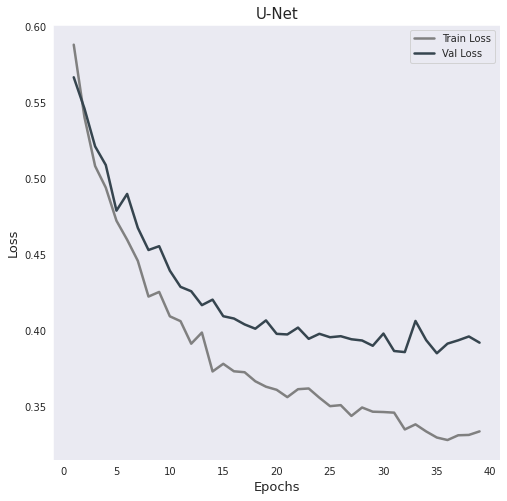

NameError: ignored

In [ ]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 4,data_path = MODEL_DIR, verbose = True, model_title = "U-Net", save = True,
             stopping_criterion = "loss")

In [ ]:
#### load the best model %%%%%%
model.load_state_dict(torch.load((MODEL_DIR +'0_checkpoint.pt'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader, device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

          precision          recall          f1-score          support

Background          0.92          0.91          0.91          30992481
Bushes          0.42          0.34          0.38          1565521
Crop Lands          0.88          0.94          0.91          12177555
Trees          0.50          0.45          0.47          1650019
Cattle Barns          nan          0.00          nan          13119
Green Houses          nan          0.00          nan          90229
Living Quarters          0.75          0.85          0.80          959140

- Total accuracy:0.8792

- Mean IoU: 0.4117

- Class probs
Background:0.997
Bushes:0.974
Crop Lands:0.999
Trees:0.985
Cattle Barns:nan
Green Houses:nan
Living Quarters:0.994


NameError: ignored

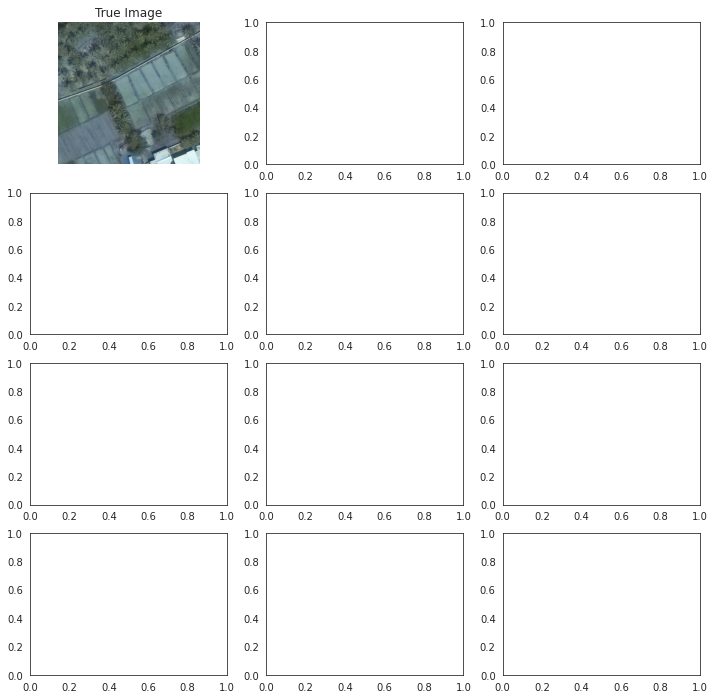

In [ ]:
# visualising the predictions 
visualize_preds(model, test_set, title = "Predictions - Vanilla UNet",
               save_title = "UNet", h = 12, w = 12, indices = [19,312,127,15])